# Predictive task description

Here are the steps:

    1. Prepare predictive model(s) of default. Default client is defined as one with loan_status variable taking on the following levels:
    Charged off
    Default
    Does not meet the credit policy. Status: Charged Off
    Late (31-120 days)

    2. Present a few competing predictive models and select one of them. Explain criteria for the selection.

    3. Calculate performance metrics you find important in this specific context, but also provide necessarily ROC graphs and AUC for comparison purposes. Metrics should be based on testing set, which should consist 30% randomly selected clients from the original dataset.

    4. If necessary, make appropriate variables' pre-processing.

    5. Send us a programming code with comments and the report/presentation of main results.

We hope you will enjoy solving the task! Good luck!

# PreProcessing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

In [2]:
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

In [3]:
# file paths
raw_data_path = os.path.join(os.path.pardir,'data','raw')
loan_data_path = os.path.join(raw_data_path, 'loan.csv')

processed_data_path = os.path.join(os.path.pardir,'data','processed')
write_train_path = os.path.join(processed_data_path, 'train.csv')
write_test_path = os.path.join(processed_data_path, 'test.csv')

figures_data_path = os.path.join(os.path.pardir, 'reports', 'figures')

In [4]:
dateColumns = ['issue_d', 'earliest_cr_line','next_pymnt_d','last_pymnt_d', 'last_credit_pull_d']

In [5]:
df = pd.read_csv(loan_data_path, low_memory=False, parse_dates=dateColumns, infer_datetime_format=True)

In [6]:
Default = ['Charged Off','Default','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']
df['Default'] = 0
df.loc[df['loan_status'].isin(Default), 'Default'] = 1

In [7]:
Active = ['Current','Late (16-30 days)','Issued','In Grace Period']
Paid = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']
Default = ['Charged Off','Default','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']
df['loan_status_type'] = 0
df.loc[df['loan_status'].isin(Active), 'loan_status_type'] = 'active'
df.loc[df['loan_status'].isin(Paid), 'loan_status_type'] = 'paid'
df.loc[df['loan_status'].isin(Default), 'loan_status_type'] = 'default'

In [8]:
df['issue_year']=df['issue_d'].dt.year
df['issue_month']=df['issue_d'].dt.month

In [9]:
data = df

# Data Visualisation

    loans per month per year

In [10]:
month_pivot = pd.pivot_table(data,values='id',index=['issue_year','issue_month'], aggfunc='count')
month_norm = pd.DataFrame(month_pivot.unstack().T.sum(), columns=['sum'])

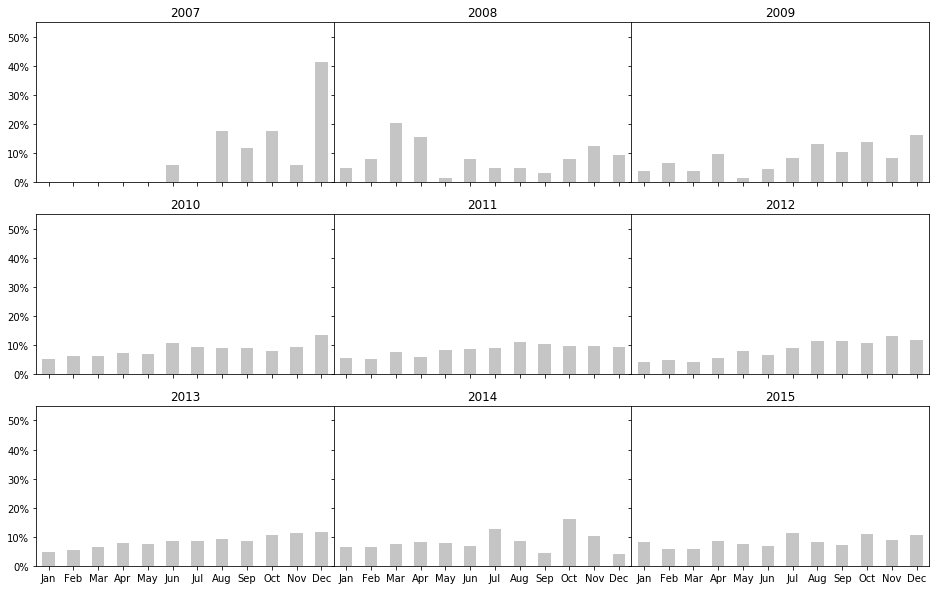

In [11]:
to_plot = month_pivot.unstack().divide(month_norm['sum'],axis=0)
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(16)
bars = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec')
y_pos = range(12)
for i in range(0, to_plot.shape[0]):
    subset = to_plot.iloc[i]
    ax = subset.plot(kind='bar', ax=axes[int(i/3),i%3], title=subset.name, ylim=(0,0.55),use_index=False, color='#C5C5C5')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    #ax.set_xticks(y_pos, bars)
    ax.set_xticklabels(bars, rotation=0)
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.title('aaa')
plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axes[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axes[:, 2]], visible=False)
fig.subplots_adjust(wspace=0)
plt.savefig(os.path.join(figures_data_path, 'Fig1.png'), bbox_inches='tight')
plt.show()

    Amount of loan in years
    Loan amount by month

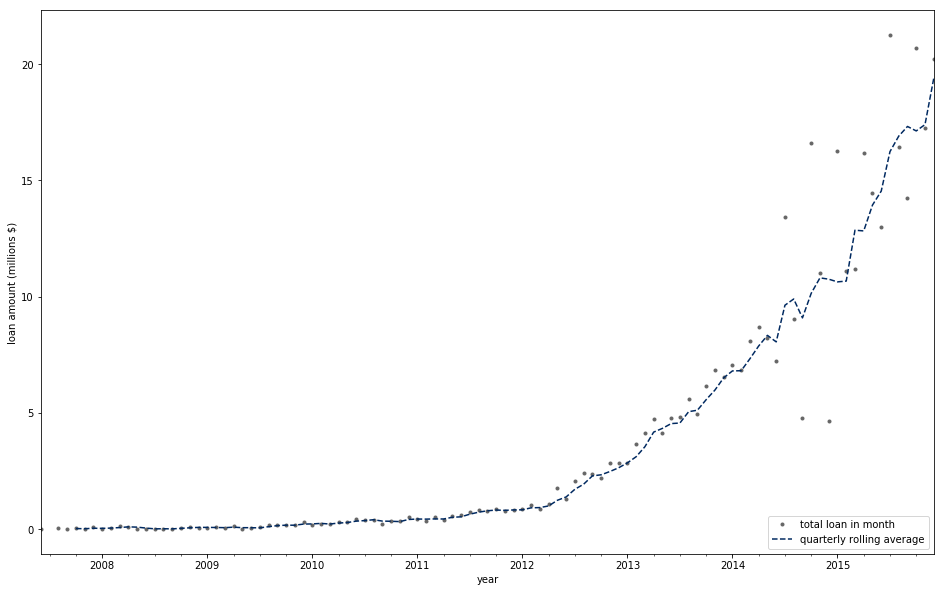

In [12]:
loan_amnt_mnth = data[['issue_d','loan_amnt']].set_index('issue_d').resample('M').sum()
ma = loan_amnt_mnth.rolling(window=3).mean()
mstd = loan_amnt_mnth.rolling(window = 3).std()
ax = data[['issue_d','loan_amnt']].set_index('issue_d').resample('M').sum().plot(style='.',figsize=(16,10), color='#666666')
ma.plot(style = '--', ax=ax, color='#002960')

scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#plt.title('aaa')
plt.xlabel('year')
plt.ylabel('loan amount (millions $)')
plt.legend(labels=['total loan in month','quarterly rolling average'], loc='lower right')
plt.savefig(os.path.join(figures_data_path, 'Fig2.png'), bbox_inches='tight')
plt.show()

    Avrage amount of loan is increasing but stabilizing around 15k USD
    Average loan amount by month

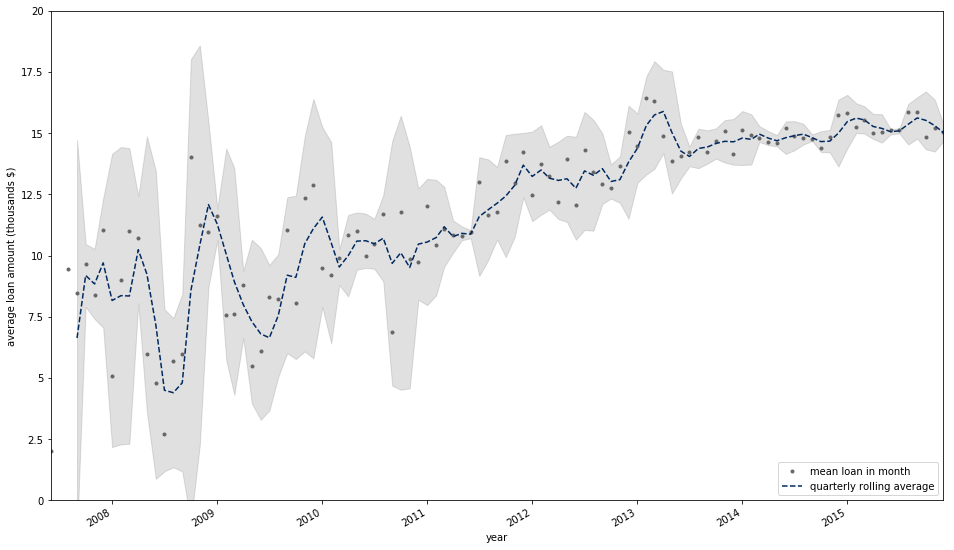

In [13]:
loan_amnt_mnth_mean = pd.pivot_table(data,values='loan_amnt', columns='issue_d',aggfunc='mean').T
ma = loan_amnt_mnth_mean.rolling(window=3).mean()
mstd = loan_amnt_mnth_mean.rolling(window = 3).std()
ax = loan_amnt_mnth_mean.plot(style='.', figsize=(16,10),ylim=(0,20000), color='#666666')
ma.plot(style = '--', ax=ax, color='#002960')
plt.fill_between(mstd.index, y1=ma['loan_amnt'].values-2*mstd['loan_amnt'].values, y2=ma['loan_amnt'].values+2*mstd['loan_amnt'].values, color='#666666', alpha=0.2)

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#plt.title('aaa')
plt.xlabel('year')
plt.ylabel('average loan amount (thousands $)')
plt.legend(labels=['mean loan in month','quarterly rolling average'], loc='lower right')
plt.savefig(os.path.join(figures_data_path, 'Fig3.png'), bbox_inches='tight')
plt.show()

    Loan amount by grade

In [14]:
grade_pivot = pd.pivot_table(data,values='id',index=['grade','sub_grade'], aggfunc='count')

In [15]:
grade_pivot_default = pd.pivot_table(data,values='Default',index=['grade','sub_grade'], aggfunc='sum')

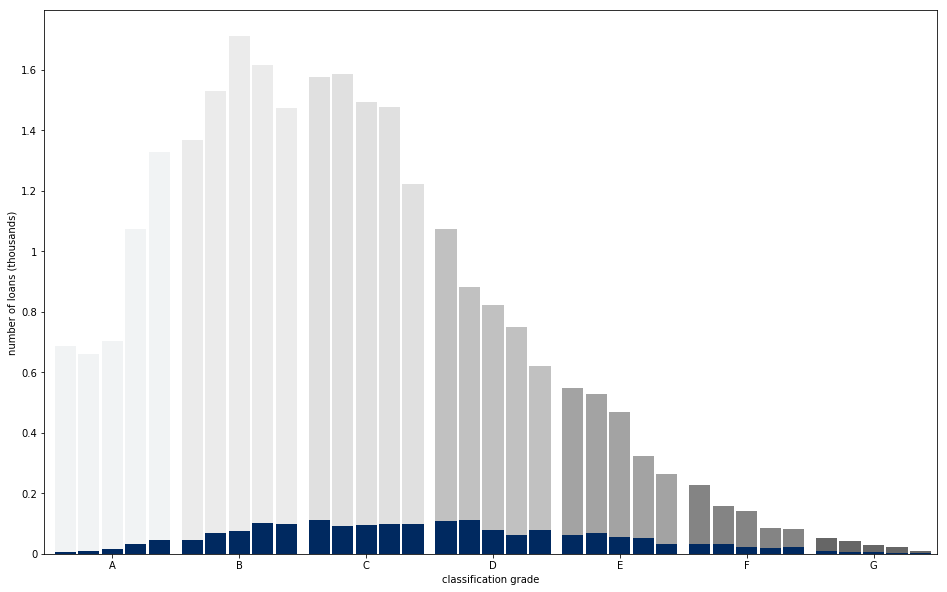

In [16]:
w=0.9
ax = grade_pivot.query('grade == ["A"]').plot(kind='bar',color='#F1F3F4',width=w,position=0,stacked=False, align = 'edge',legend=False,  figsize=(16,10), use_index=False)
grade_pivot.query('grade == ["B"]').plot(kind='bar',color='#EBEBEB',width=w,position=-6,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["C"]').plot(kind='bar',color='#666666',alpha=0.2,width=w,position=-12,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["D"]').plot(kind='bar',color='#666666',alpha=0.4,width=w,position=-18,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["E"]').plot(kind='bar',color='#666666',alpha=0.6,width=w,position=-24,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["F"]').plot(kind='bar',color='#666666',alpha=0.8,width=w,position=-30,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["G"]').plot(kind='bar',color='#666666',width=w,position=-36,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)

default_color = '#002960'
grade_pivot_default.query('grade == ["A"]').plot(kind='bar',color=default_color,width=w,position=0,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["B"]').plot(kind='bar',color=default_color,width=w,position=-6,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["C"]').plot(kind='bar',color=default_color,width=w,position=-12,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["D"]').plot(kind='bar',color=default_color,width=w,position=-18,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["E"]').plot(kind='bar',color=default_color,width=w,position=-24,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["F"]').plot(kind='bar',color=default_color,width=w,position=-30,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["G"]').plot(kind='bar',color=default_color,width=w,position=-36,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)

bars = ('A', 'B', 'C', 'D', 'E', 'F', 'G')
y_pos = [2.9,8.3,13.7,19.1,24.5,29.9,35.3]

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.xticks(rotation=0)
plt.xticks(y_pos, bars)
#plt.title('aaa')
plt.xlabel('classification grade')
plt.ylabel('number of loans (thousands)')
plt.savefig(os.path.join(figures_data_path, 'Fig4.png'), bbox_inches='tight')
plt.show()

    Distribution of purpose segmantated by years

In [17]:
purpose_pivot = pd.pivot_table(data,values='id',index=['issue_year','purpose'], aggfunc='count')
purpose_norm = pd.DataFrame(purpose_pivot.unstack().T.sum(), columns=['sum'])

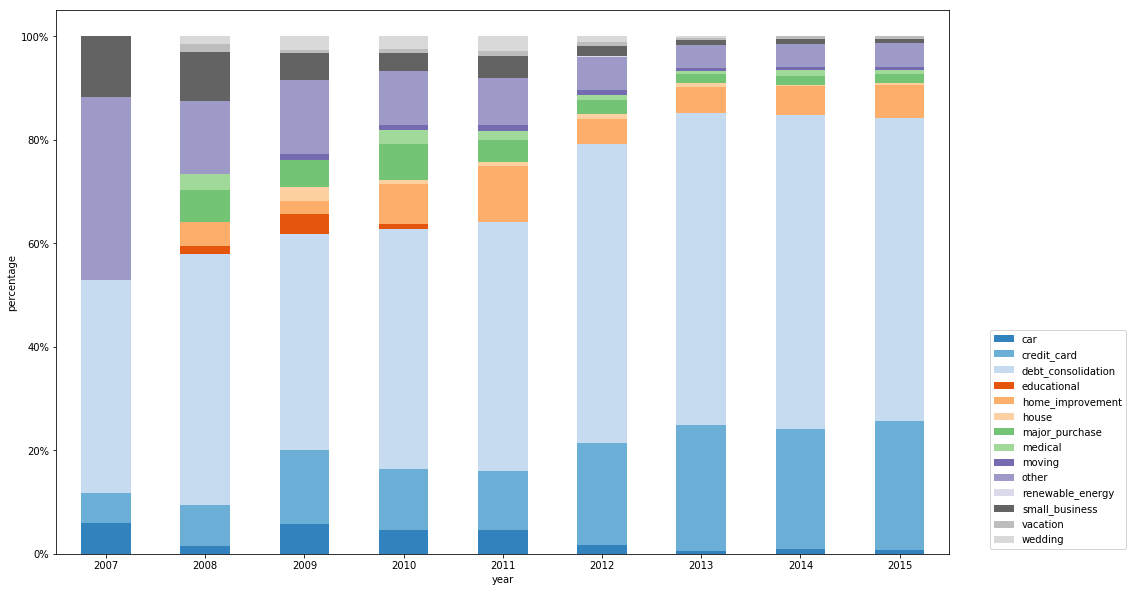

In [18]:
from matplotlib.ticker import FuncFormatter
leg_leb=data['purpose'].value_counts().sort_index().index
ax = purpose_pivot.unstack().divide(purpose_norm['sum'],axis=0).plot(kind='bar',stacked=True, figsize=(16,10),colormap='tab20c')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig5.png'), bbox_inches='tight')
plt.show()

    Purpose rectangle (treemap) map (color represent avrage amount of loan by type)

In [19]:
data['purpose'].value_counts()/data.shape[0]

debt_consolidation    0.587731
credit_card           0.233350
home_improvement      0.059577
other                 0.049134
major_purchase        0.019834
small_business        0.011532
car                   0.010368
medical               0.009241
moving                0.006123
vacation              0.004921
house                 0.004696
wedding               0.002667
educational           0.000413
renewable_energy      0.000413
Name: purpose, dtype: float64

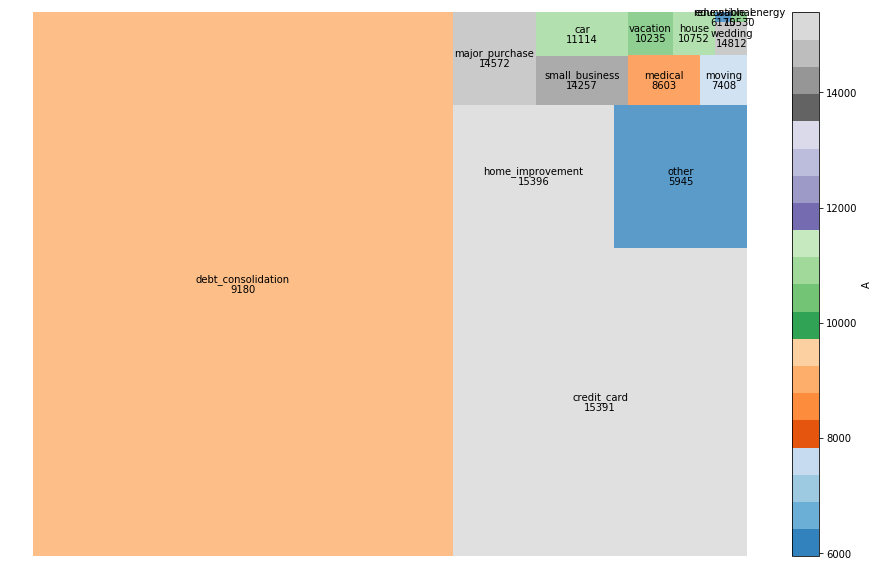

In [20]:
# libraries
import matplotlib
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)

purpose_sizes = data['purpose'].value_counts().values
purpose_values= data.groupby(by='purpose')['loan_amnt'].mean().values.astype(int)
purpose_labels= data['purpose'].value_counts().index

# create a color palette, mapped to these values
cmap = matplotlib.cm.tab20c
mini=min(purpose_values)
maxi=max(purpose_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in purpose_values]

plt.figure(figsize=(16, 10))
# If you have a data frame?
squarify.plot(sizes= purpose_sizes, label=purpose_labels, alpha=.8, value=purpose_values,color=colors)
plt.axis('off')

img = plt.imshow([purpose_values], cmap=cmap,aspect='auto')
img.set_visible(False)

#cax = plt.axes([0.95, 0.1, 0.02, 0.5])

plt.colorbar(img, orientation="vertical", label='A')
plt.savefig(os.path.join(figures_data_path, 'Fig6.png'), bbox_inches='tight')
plt.show() 

    Maps

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go

In [22]:
import plotly
plotly.tools.set_credentials_file(username='michalnawrot', api_key='6LRMTWexot66piGco8ct')

In [23]:
state_count = pd.DataFrame(data['addr_state'].value_counts()).reset_index()
state_count.columns=['addr_state','state_count']

In [24]:
state_amnt = pd.pivot_table(data,values='loan_amnt',index=['addr_state'], aggfunc='sum').reset_index()
state_amnt.columns=['addr_state','state_amnt']

In [25]:
# state population from wiki https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
state_pop = {'CA' : 39144818,
'TX' : 27469144,
'FL' : 20271878,
'NY' : 19795791,
'IL' : 12859995,
'PA' : 12802503,
'OH' : 11613423,
'GA' : 10214860,
'NC' : 10042802,
'MI' : 9922576,
'NJ' : 8958013,
'VA' : 8382993,
'WA' : 7170351,
'AZ' : 6828065,
'MA' : 6794422,
'IN' : 6619680,
'TN' : 6600299,
'MO' : 6083672,
'MD' : 6006401,
'WI' : 5771337,
'MN' : 5489594,
'CO' : 5456574,
'SC' : 4896146,
'AL' : 4858979,
'LA' : 4670724,
'KY' : 4425092,
'OR' : 4028977,
'OK' : 3911338,
'CT' : 3890886,
'IA' : 3123899,
'UT' : 2995919,
'MS' : 2992333,
'AR' : 2978204,
'KS' : 2911641,
'NV' : 2890845,
'NM' : 2085109,
'NE' : 1896190,
'WV' : 1844128,
'ID' : 1654930,
'HI' : 1431603,
'NH' : 1330608,
'ME' : 1329328,
'RI' : 1053298,
'MT' : 1032949,
'DE' : 945934,
'SD' : 858469,
'ND' : 756927,
'AK' : 738432,
'DC' : 672228,
'VT' : 626042,
'WY' : 586107}
state_pop = pd.DataFrame.from_dict(state_pop, orient = 'index').reset_index()
state_pop.columns = ['addr_state', 'state_pop']

In [26]:
state_table = pd.merge(state_pop, state_amnt, on=['addr_state'], how='left')
state_table = pd.merge(state_table, state_count, on=['addr_state'], how='left')
state_table['state_amnt_per_capita'] = state_table['state_amnt']/state_table['state_pop']
state_table['state_count_per_capita'] = state_table['state_count']/state_table['state_pop']

    Amount of loan per capita US

In [27]:
trc = dict(
    type='choropleth',
    locations = state_table['addr_state'],
    locationmode = 'USA-states',
    colorscale = ['Blues'],
    z = state_table['state_amnt_per_capita'])
lyt = dict(geo=dict(scope='usa'))
mapfig = go.Figure(data=[trc], layout = lyt)
py.image.save_as(mapfig, filename=os.path.join(figures_data_path, 'Fig7a.png'), scale=3)
py.iplot(mapfig)

    default, active and paid loans issued in different years

In [28]:
default_pivot = pd.pivot_table(data,values='id',index=['issue_year','loan_status_type'], aggfunc='count')

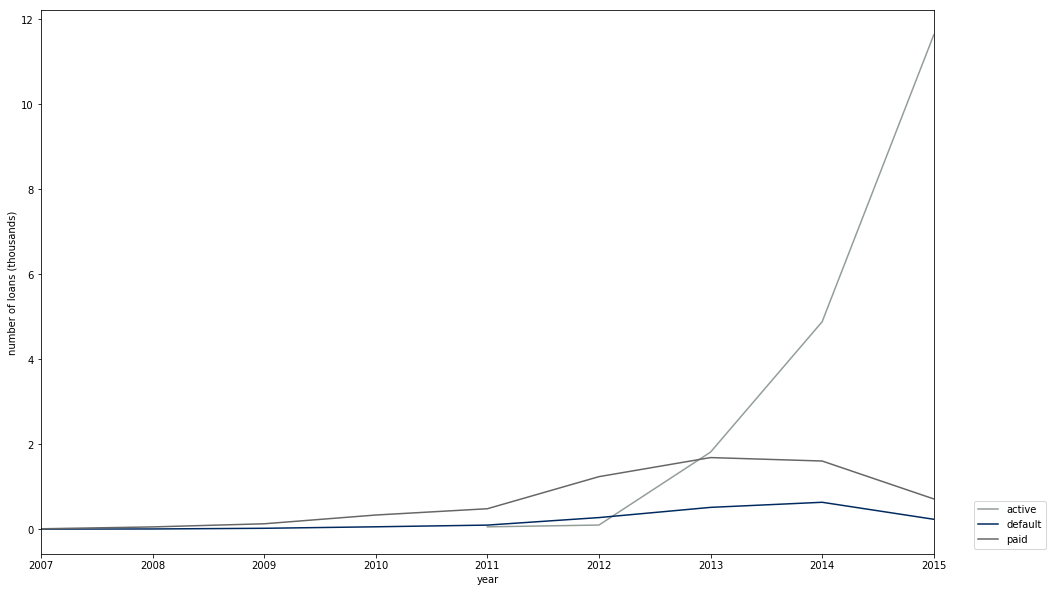

In [29]:
ax = default_pivot.unstack().plot(style='-',color=['#939D98','#002960','#666666'],figsize=(16,10))

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.xlabel('year')
plt.ylabel('number of loans (thousands)')
plt.legend(['active', 'default', 'paid'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig8.png'), bbox_inches='tight')
plt.show()

    Changes in percantage of default, active and paid loans issued in different years

In [30]:
default_pivot = pd.pivot_table(data,values='id',index=['issue_year','loan_status_type'], aggfunc='count')
default_norm = pd.DataFrame(default_pivot.unstack().T.sum(), columns=['sum'])

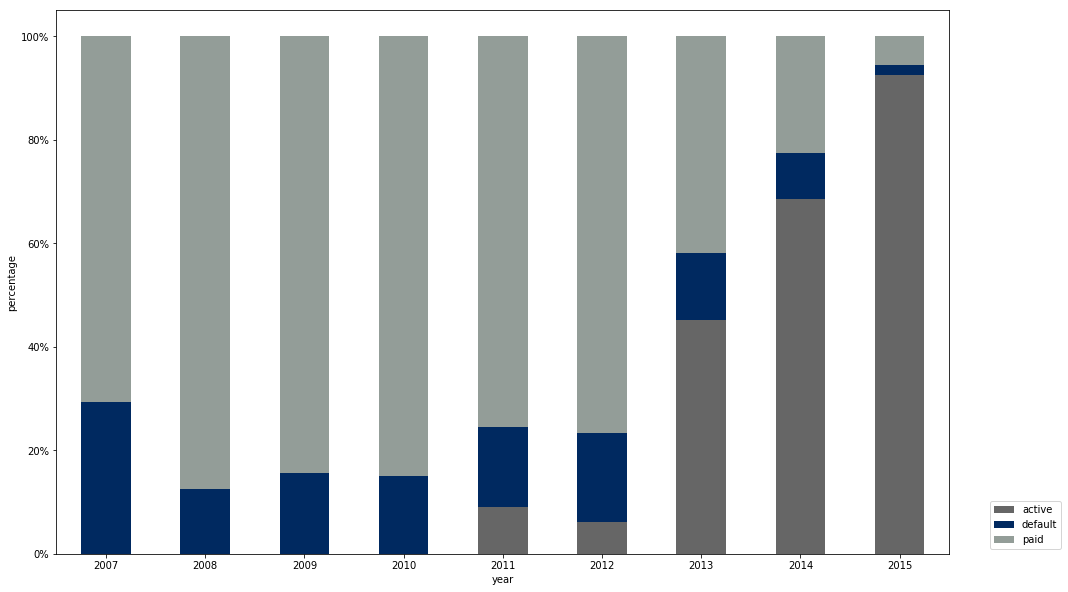

In [31]:
ax = default_pivot.unstack().divide(default_norm['sum'],axis=0).plot(kind='bar',stacked=True, figsize=(16,10), color=['#666666','#002960','#939D98'])
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(['active', 'default', 'paid'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig9.png'), bbox_inches='tight')
plt.show()

    Different purpose - different grade

In [32]:
grade_pivot = pd.pivot_table(data,values='id',index=['grade','purpose'], aggfunc='count')
grade_norm = pd.DataFrame(grade_pivot.unstack().T.sum(), columns=['sum'])

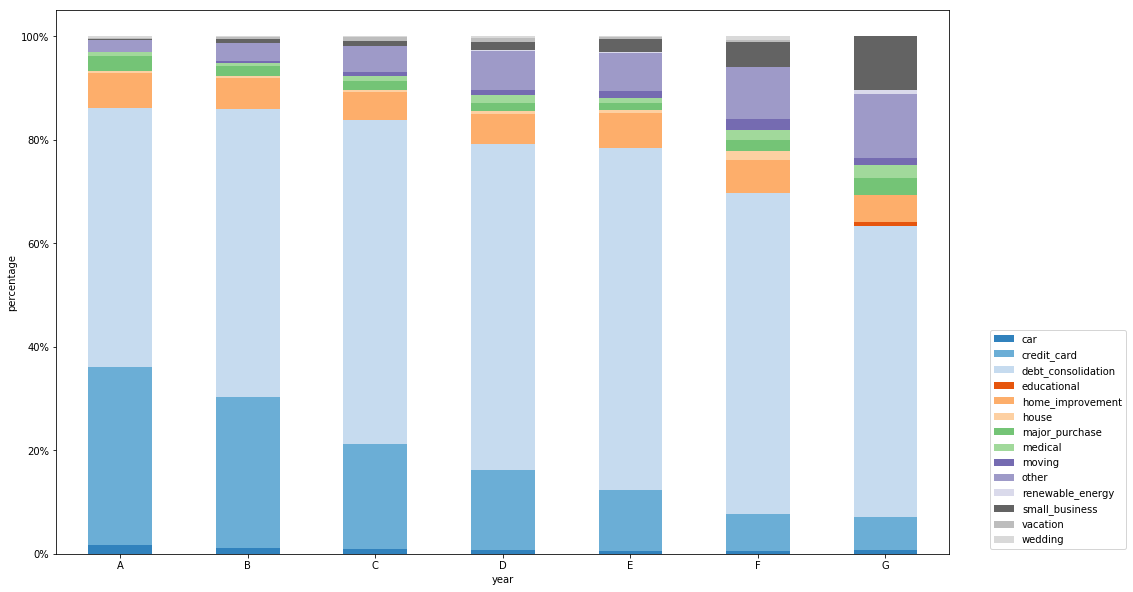

In [33]:
leg_leb=data['purpose'].value_counts().sort_index().index
ax = grade_pivot.unstack().divide(grade_norm['sum'],axis=0).plot(kind='bar',stacked=True,colormap='tab20c',figsize=(16,10))
plt.xlabel('year')
plt.xticks(rotation=0)
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig10.png'), bbox_inches='tight')
plt.show()

    Grade vs loan status type

In [34]:
grade_status_pivot = pd.pivot_table(data,values='id',index=['grade','loan_status_type'], aggfunc='count')
grade_status_norm = pd.DataFrame(grade_status_pivot.unstack().T.sum(), columns=['sum'])

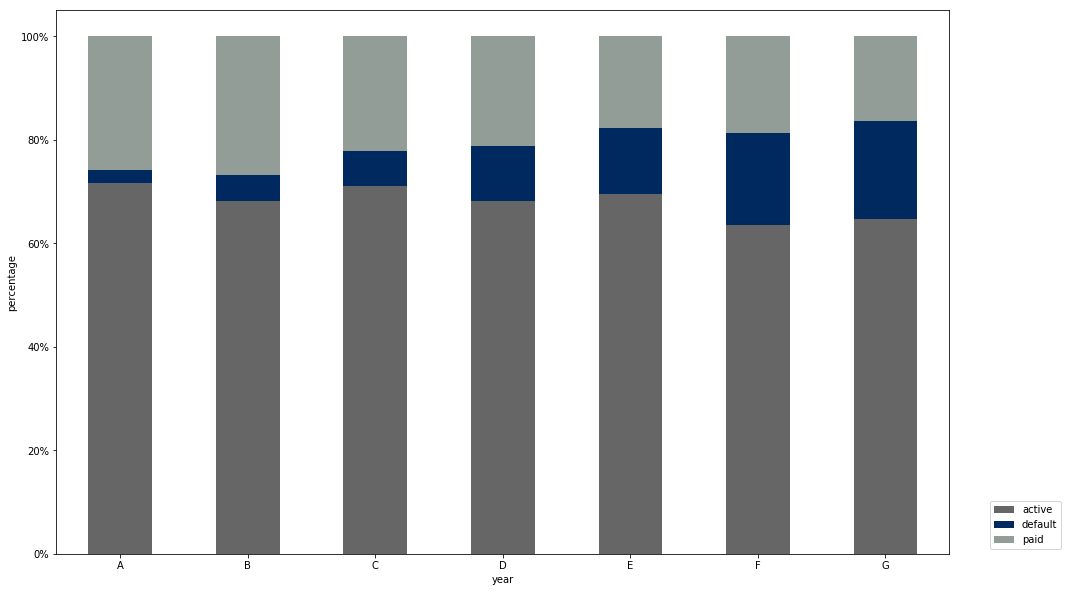

In [35]:
leg_leb=data['loan_status_type'].value_counts().sort_index().index
ax = grade_status_pivot.unstack().divide(grade_status_norm['sum'],axis=0).plot(kind='bar',stacked=True, color=['#666666','#002960','#939D98'],figsize=(16,10))
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig11.png'), bbox_inches='tight')
plt.show()

    box plot the higher the grade (more risky loan) the higher the interest rates

C:\Users\michal.nawrot\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



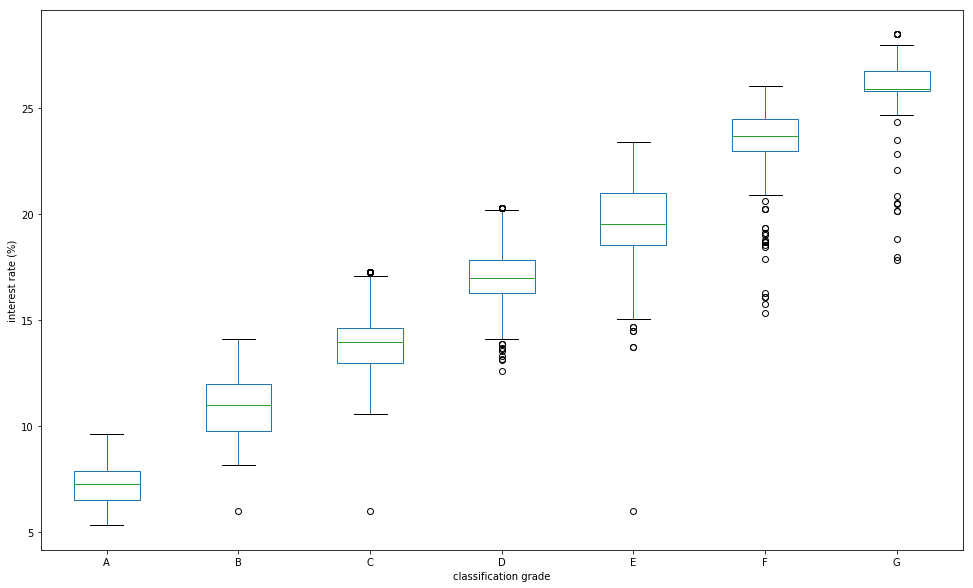

In [36]:
data.boxplot(column='int_rate',by='grade',figsize=(16,10),grid=False)
plt.xticks(rotation=0)
plt.xlabel('classification grade')
plt.ylabel('interest rate (%)')
plt.title("")
plt.suptitle("")
plt.savefig(os.path.join(figures_data_path, 'Fig12.png'), bbox_inches='tight')
plt.show()

    interest rate in time per loan term 
    Interest rate distribution by grade and by term

In [37]:
int_rate_table = pd.pivot_table(data,values='int_rate',index=['term','issue_year','grade'], aggfunc='mean').unstack()
int_rate_table_36 = int_rate_table.query('term == [" 36 months"]')
int_rate_table_60 = int_rate_table.query('term == [" 60 months"]')

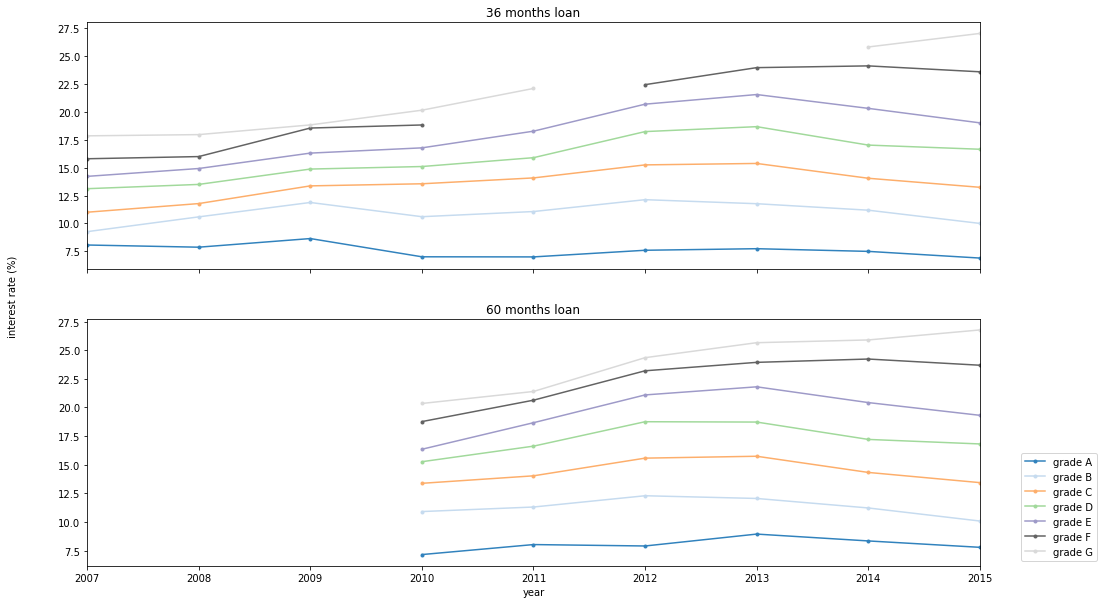

In [38]:
bars = (2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015)
y_pos_36 = (0, 1, 2, 3, 4, 5, 6, 7, 8)
y_pos_60 = (-3,-2,-1,0, 1, 2, 3, 4, 5)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(16)
#fig.text(0.5, 0.04, 'interest rate (%)', ha='center', va='center')
fig.text(0.06, 0.5, 'interest rate (%)', ha='center', va='center', rotation='vertical')
int_rate_table_36.plot(style='.-', legend=False, ax=axes[0], title='36 months loan', colormap='tab20c',use_index=False)
int_rate_table_60.plot(style='.-', legend=False, ax=axes[1], title='60 months loan', colormap='tab20c',use_index=False)
plt.xticks(y_pos_60, bars)
plt.setp(axes[0].get_xticklabels(), visible=False)
plt.xlabel('year')
#plt.ylabel('interest rate (%)')
plt.legend(['grade A', 'grade B','grade C','grade D','grade E','grade F','grade G'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig13.png'), bbox_inches='tight')
plt.show()